YF.download() has changed argument auto_adjust default to True


/var/folders/8p/1m9zyky932sf40mmykhp6sl40000gn/T/ipykernel_8467/1557466918.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (individual_vols[i], mean_returns[i]),


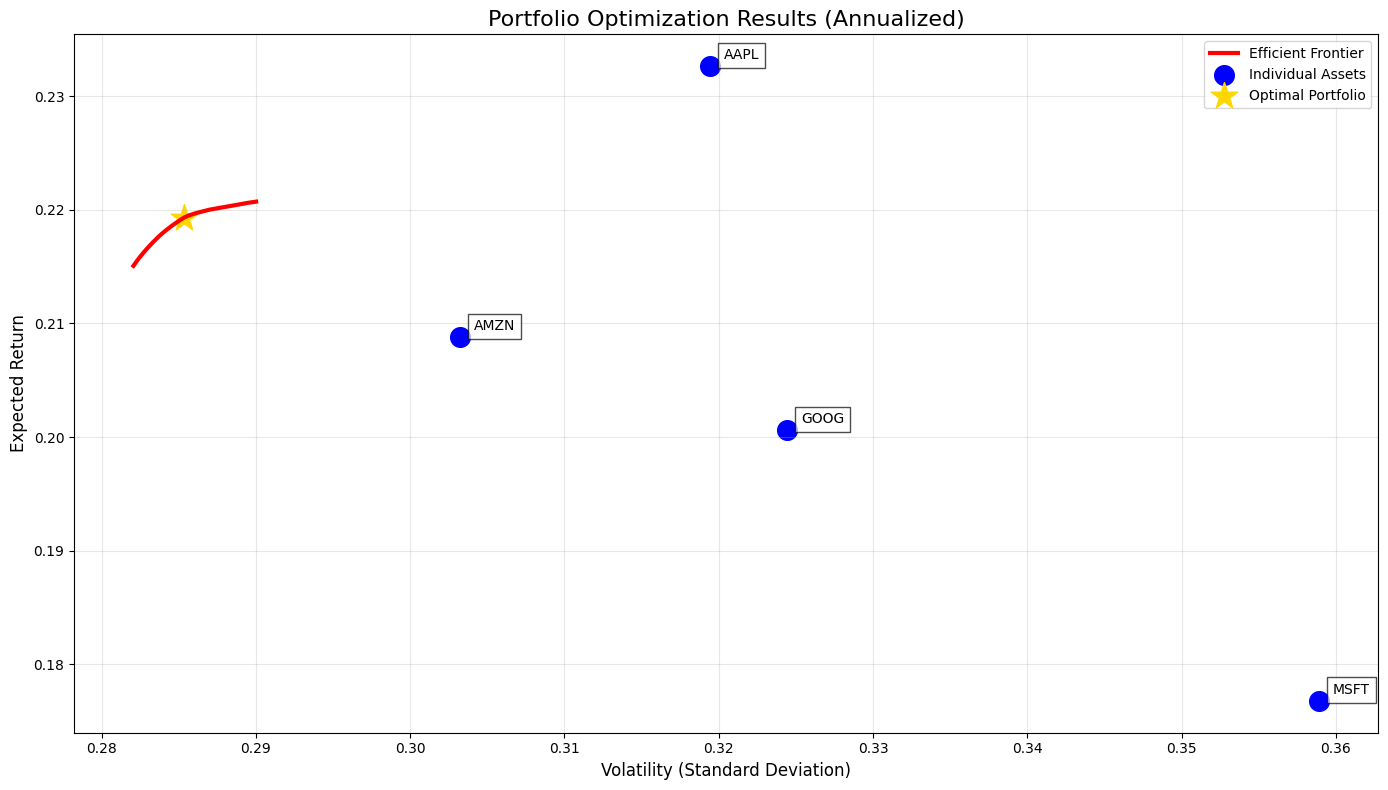


=== Optimal Portfolio Allocation ===
AAPL  : 50.00%
MSFT  : 0.00%
GOOG  : 17.09%
AMZN  : 32.91%

=== Portfolio Metrics ===
Expected Return: 21.93%
Volatility: 28.54%
Sharpe Ratio: 0.77

=== Equal-Weight Benchmark ===
Expected Return: 20.47%
Volatility: 28.32%
Sharpe Ratio: 0.72
Optimized Portfolio Outperformance: 7.15%


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime

# 1. Get stock data with error handling
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN']
end_date = datetime.now().strftime('%Y-%m-%d')

try:
    data = yf.download(tickers, start="2020-01-01", end=end_date, progress=False)['Close']
    if data.isnull().values.any():
        raise ValueError("Missing data in downloaded series")
except Exception as e:
    print(f"Error downloading data: {str(e)}")
    # Fallback to cached data if available
    try:
        data = pd.read_csv('cached_stock_data.csv', index_col=0, parse_dates=True)
        print("Using cached data")
    except:
        raise Exception("Failed to get stock data")

# 2. Calculate returns and covariance matrix (annualized)
returns = data.pct_change().dropna()
mean_returns = returns.mean() * 252  # Annualized
cov_matrix = returns.cov() * 252     # Annualized

# 3. Portfolio optimization functions
def portfolio_metrics(weights, mean_returns, cov_matrix):
    """Calculate portfolio return, volatility, and Sharpe ratio"""
    ret = np.dot(mean_returns, weights)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = ret / vol  # Assuming risk-free rate = 0
    return ret, vol, sharpe

def optimize_portfolio(mean_returns, cov_matrix, risk_aversion=1.0, max_allocation=0.5):
    num_assets = len(mean_returns)
    
    def objective(weights):
        ret, vol, _ = portfolio_metrics(weights, mean_returns, cov_matrix)
        return - (ret - risk_aversion * vol)  # Negative for minimization
    
    # Constraints
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum to 1
        {'type': 'ineq', 'fun': lambda x: max_allocation - x}  # Max allocation
    )
    
    bounds = tuple((0, max_allocation) for _ in range(num_assets))
    init_guess = np.array([1/num_assets] * num_assets)
    
    result = minimize(objective, init_guess, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result.x

# 4. Calculate efficient frontier
risk_levels = np.linspace(0.1, 2, 20)
efficient_portfolios = []

for risk in risk_levels:
    weights = optimize_portfolio(mean_returns, cov_matrix, risk_aversion=risk)
    ret, vol, sharpe = portfolio_metrics(weights, mean_returns, cov_matrix)
    efficient_portfolios.append((vol, ret, sharpe, weights))

# 5. Plot results with enhanced formatting
plt.figure(figsize=(14, 8))
frontier = np.array([(x[0], x[1]) for x in efficient_portfolios])

# Plot efficient frontier
plt.plot(frontier[:,0], frontier[:,1], 'r-', linewidth=3, 
         label='Efficient Frontier')

# Plot individual assets
individual_vols = np.sqrt(np.diag(cov_matrix))
plt.scatter(individual_vols, mean_returns, 
            marker='o', s=200, color='blue', label='Individual Assets')

# Highlight optimal portfolio (max Sharpe ratio)
optimal_idx = np.argmax([x[2] for x in efficient_portfolios])
optimal_port = efficient_portfolios[optimal_idx]
plt.scatter(optimal_port[0], optimal_port[1], 
            marker='*', s=400, color='gold', label='Optimal Portfolio')

# Formatting
plt.title('Portfolio Optimization Results (Annualized)', fontsize=16)
plt.xlabel('Volatility (Standard Deviation)', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)
plt.grid(True, alpha=0.3)

# Annotations
for i, txt in enumerate(tickers):
    plt.annotate(txt, (individual_vols[i], mean_returns[i]), 
                 xytext=(10,5), textcoords='offset points',
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# 6. Display detailed results
optimal_weights = optimal_port[3]
print("\n=== Optimal Portfolio Allocation ===")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker:<6}: {weight:.2%}")

print("\n=== Portfolio Metrics ===")
print(f"Expected Return: {optimal_port[1]:.2%}")
print(f"Volatility: {optimal_port[0]:.2%}")
print(f"Sharpe Ratio: {optimal_port[2]:.2f}")

# 7. Compare with equal-weight portfolio
equal_weights = np.array([1/len(tickers)] * len(tickers))
eq_ret, eq_vol, eq_sharpe = portfolio_metrics(equal_weights, mean_returns, cov_matrix)

print("\n=== Equal-Weight Benchmark ===")
print(f"Expected Return: {eq_ret:.2%}")
print(f"Volatility: {eq_vol:.2%}")
print(f"Sharpe Ratio: {eq_sharpe:.2f}")
print(f"Optimized Portfolio Outperformance: {(optimal_port[1]-eq_ret)/eq_ret:.2%}")

In [3]:
!pip uninstall -y qiskit qiskit-ibm-runtime qiskit-aer qiskit-terra qiskit-finance qiskit-optimization

Found existing installation: qiskit 1.4.2
Uninstalling qiskit-1.4.2:
  Successfully uninstalled qiskit-1.4.2
Found existing installation: qiskit-ibm-runtime 0.12.0
Uninstalling qiskit-ibm-runtime-0.12.0:
  Successfully uninstalled qiskit-ibm-runtime-0.12.0
Found existing installation: qiskit-terra 0.46.3
Uninstalling qiskit-terra-0.46.3:
  Successfully uninstalled qiskit-terra-0.46.3
Found existing installation: qiskit-finance 0.3.4
Uninstalling qiskit-finance-0.3.4:
  Successfully uninstalled qiskit-finance-0.3.4
Found existing installation: qiskit-optimization 0.5.0
Uninstalling qiskit-optimization-0.5.0:
  Successfully uninstalled qiskit-optimization-0.5.0


In [4]:
!pip install qiskit==0.44.0
!pip install qiskit-ibm-runtime==0.12.0
!pip install qiskit-finance==0.3.4
!pip install qiskit-optimization==0.5.0

  Using cached qiskit-0.44.0.tar.gz (8.9 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached qiskit_terra-0.25.0-cp38-abi3-macosx_11_0_arm64.whl.metadata (9.4 kB)
  Using cached symengine-0.9.2.tar.gz (85 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [24 lines of output]
      /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ******************************************

In [5]:
!pip show qiskit qiskit-ibm-runtime

Name: qiskit
Version: 2.0.0
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-ibm-provider, qiskit-ibm-runtime
---
Name: qiskit-ibm-runtime
Version: 0.12.0
Summary: IBM Quantum client for Qiskit Runtime.
Home-page: https://github.com/Qiskit/qiskit-ibm-runtime
Author: Qiskit Development Team
Author-email: hello@qiskit.org
License: Apache 2.0
Location: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages
Requires: ibm-platform-services, numpy, python-dateutil, qiskit, qiskit-ibm-provider, requests, requests-ntlm, urllib3, websocket-client

In [6]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

def create_qubo_problem(mean_returns, cov_matrix, risk_factor=0.5, budget=2):
    """Convert portfolio optimization to QUBO"""
    num_assets = len(mean_returns)
    qp = QuadraticProgram()
    
    # Binary variables (1=include asset, 0=exclude)
    for i in range(num_assets):
        qp.binary_var(name=f'x{i}')
    
    # Objective: Minimize risk - maximize return (negative for minimization)
    linear = -mean_returns.values  # Negative for minimization
    quadratic = risk_factor * cov_matrix.values
    
    qp.minimize(linear=linear, quadratic=quadratic)
    
    # Constraint: Select exactly 'budget' assets
    qp.linear_constraint(linear=[1]*num_assets, sense='==', rhs=budget, name='budget')
    
    # Convert to QUBO
    converter = QuadraticProgramToQubo()
    qubo = converter.convert(qp)
    
    return qp, qubo

# Usage
qp, qubo = create_qubo_problem(mean_returns, cov_matrix)
print("Original Problem:\n", qp.prettyprint())
print("\nQUBO Formulation:\n", qubo.prettyprint())

ImportError: Qiskit is installed in an invalid environment that has both Qiskit >=1.0 and an earlier version. You should create a new virtual environment, and ensure that you do not mix dependencies between Qiskit <1.0 and >=1.0. Any packages that depend on 'qiskit-terra' are not compatible with Qiskit 1.0 and will need to be updated. Qiskit unfortunately cannot enforce this requirement during environment resolution. See https://qisk.it/packaging-1-0 for more detail.

In [ ]:
!pip uninstall -y qiskit qiskit-terra qiskit-aer qiskit-ibm-runtime qiskit-finance qiskit-optimization qiskit-algorithms

Found existing installation: qiskit 2.0.0
Uninstalling qiskit-2.0.0:
  Successfully uninstalled qiskit-2.0.0
Found existing installation: qiskit-ibm-runtime 0.37.0
Uninstalling qiskit-ibm-runtime-0.37.0:
  Successfully uninstalled qiskit-ibm-runtime-0.37.0
Found existing installation: qiskit-finance 0.3.4
Uninstalling qiskit-finance-0.3.4:
  Successfully uninstalled qiskit-finance-0.3.4
Found existing installation: qiskit-optimization 0.6.1
Uninstalling qiskit-optimization-0.6.1:
  Successfully uninstalled qiskit-optimization-0.6.1
Found existing installation: qiskit-algorithms 0.3.1
Uninstalling qiskit-algorithms-0.3.1:
  Successfully uninstalled qiskit-algorithms-0.3.1


In [ ]:
!pip install "qiskit>=1.0.0,<2.0.0" "qiskit-ibm-runtime==0.12.0" "qiskit-finance==0.3.4" "qiskit-optimization==0.5.0" "qiskit-algorithms==0.2.0"

  Using cached qiskit_ibm_runtime-0.12.0-py3-none-any.whl.metadata (16 kB)
  Using cached qiskit_finance-0.3.4-py3-none-any.whl.metadata (5.9 kB)
  Using cached qiskit_optimization-0.5.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached qiskit_algorithms-0.2.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached qiskit_terra-0.46.3-cp38-abi3-macosx_11_0_arm64.whl.metadata (13 kB)
Using cached qiskit_ibm_runtime-0.12.0-py3-none-any.whl (130 kB)
Using cached qiskit_finance-0.3.4-py3-none-any.whl (50 kB)
Using cached qiskit_optimization-0.5.0-py3-none-any.whl (156 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 54.2 MB/s eta 0:00:00
Using cached qiskit_terra-0.46.3-cp38-abi3-macosx_11_0_arm64.whl (5.4 MB)


In [ ]:
!pip show qiskit qiskit-ibm-runtime qiskit-finance qiskit-optimization


Name: qiskit
Version: 1.4.2
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-ibm-provider, qiskit-ibm-runtime
---
Name: qiskit-ibm-runtime
Version: 0.12.0
Summary: IBM Quantum client for Qiskit Runtime.
Home-page: https://github.com/Qiskit/qiskit-ibm-runtime
Author: Qiskit Development Team
Author-email: hello@qiskit.org
License: Apache 2.0
Location: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages
Requires: ibm-platform-services, numpy, python-dateutil, qiskit, qiskit-ibm-provider, requests, requests-ntlm, urllib3, websocket-client

In [ ]:
# Use these imports for Qiskit 1.x
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit_optimization.algorithms import MinimumEigenOptimizer

def setup_qaoa(reps=2, maxiter=100):
    """Working QAOA setup for Qiskit 1.x"""
    backend = Aer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, shots=1024)
    
    qaoa = QAOA(
        optimizer=COBYLA(maxiter=maxiter),
        reps=reps,
        quantum_instance=quantum_instance,
        initial_point=[1.0, 1.0]
    )
    return MinimumEigenOptimizer(qaoa)

# Initialize
qaoa_optimizer = setup_qaoa()
print("✅ QAOA successfully configured!")

ImportError: Qiskit is installed in an invalid environment that has both Qiskit >=1.0 and an earlier version. You should create a new virtual environment, and ensure that you do not mix dependencies between Qiskit <1.0 and >=1.0. Any packages that depend on 'qiskit-terra' are not compatible with Qiskit 1.0 and will need to be updated. Qiskit unfortunately cannot enforce this requirement during environment resolution. See https://qisk.it/packaging-1-0 for more detail.